#### Task 1

In [1]:
%matplotlib inline
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
import numpy as np

C:\Users\QP\AppData\Local\Temp\ipykernel_24952\3742306120.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(figure)


(5804, 9)
(5804, 3, 3)


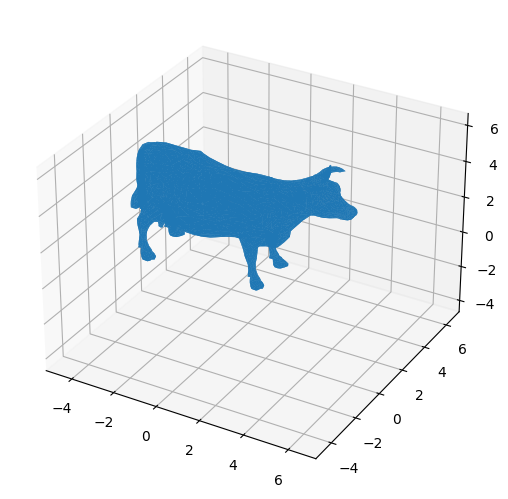

In [2]:
# %matplotlib 
%matplotlib inline
figure = plt.figure()
axes = mplot3d.Axes3D(figure)
mesh_cow = mesh.Mesh.from_file('cow.stl')
print(mesh_cow.points.shape) #(5804, 9) Each triangular face of the cow in column view
print(mesh_cow.vectors.shape) #(5804, 3, 3) Each triangular face of the cow in 3x3 view. Each row represents a vertex.
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh_cow.vectors))
#Add the 3D faces to the created matplotlib axes
min = np.min(mesh_cow.vectors.reshape(-1))
max = np.max(mesh_cow.vectors.reshape(-1))#Find minimum and maximum units to place the cow in a cubular grid
axes.auto_scale_xyz([min, max], [min, max], [min, max])
plt.show()

In [3]:
def homogenousTransform3D(src: np.ndarray, H: np.ndarray) -> np.ndarray:
    """
    Returns the homography transform of a 3D point in homogenous space.
        
        Parameters:
                src (numpy.ndarray): Input coordinate in homogenous space.
                H   (numpy.ndarray): Transformation matrix.
        Returns:
                Transformed coordinate in homogenous space.
    """
    return np.matmul(H, src)

In [4]:
# Create transformation matrix
scale = 0.5
rotation = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=np.float32)
translation = np.array([[1.5], [-2.5], [0]], dtype=np.float32)
homography = np.array([[0], [0], [0]], dtype=np.float32)

H = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))
print(H)

[[ 0.5  0.   0.   1.5]
 [ 0.   0.5  0.  -2.5]
 [ 0.   0.   0.5  0. ]
 [ 0.   0.   0.   1. ]]


In [5]:
def transformMeshbyH(src, H):
    # Transform each vector in mesh
    transformed = np.zeros_like(src)
    for i in range(src.shape[0]):
        for j in range(src.shape[1]):
            hr = np.reshape(np.hstack((src[i,j], np.array([1], dtype=np.float32))), (-1,1))
            hr_hat = homogenousTransform3D(hr, H)
            transformed[i, j] = hr_hat.reshape((4))[:3]/hr_hat.reshape((4))[-1]
    return transformed

In [6]:
calf = transformMeshbyH(mesh_cow.vectors, H)

C:\Users\QP\AppData\Local\Temp\ipykernel_24952\2649510449.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(figure)


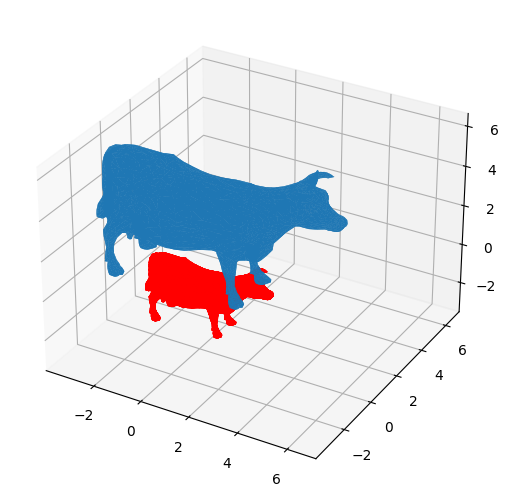

In [7]:
# %matplotlib 
%matplotlib inline
figure = plt.figure()
axes = mplot3d.Axes3D(figure)
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh_cow.vectors))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(calf, edgecolors='r', facecolors='r'))
#Add the 3D faces to the created matplotlib axes
min = np.min(calf.reshape(-1))
max = np.max(mesh_cow.vectors.reshape(-1))#Find minimum and maximum units to place the cow in a cubular grid
axes.auto_scale_xyz([min, max], [min, max], [min, max])
plt.show()

#### Task 2

In [8]:
def hatOperator(src: np.ndarray) -> np.ndarray:
    """
    Calculates the hat matrix of a vector.
        
        Parameters:
                src (numpy.ndarray): Input coordinate in euclidean space.
        Returns:
                Hat matrix.
    """
    return np.array([[0,       0-src[2], src[1] ],
                     [src[2] , 0,       0-src[0]],
                     [0-src[1], src[0] , 0      ]], dtype=np.float32)

In [9]:
def RodriguesFormula(theta: np.float32, hatMatrix: np.ndarray) -> np.ndarray:
    """
    Calculates the rotation matrix from theta to rotate around an axis which is supplied by a hat matrix of the axis.
        
        Parameters:
                theta       (numpy.ndarray): Rotation amount in radian.
                hatMatrix   (numpy.ndarray): Hat matrix.
        Returns:
                Rotation matrix.
    """
    return np.eye(3, dtype=np.float32) + np.sin(theta)*hatMatrix + (1 - np.cos(theta))*np.matmul(hatMatrix, hatMatrix)

### Alternative function
# def RodriguesFormula2(theta: np.float32, hatMatrix: np.ndarray, axis) -> np.ndarray:
#     """
#     Calculates the rotation matrix from theta to rotate around an axis which is supplied by a hat matrix of the axis.
        
#         Parameters:
#                 theta       (numpy.ndarray): Rotation amount in radian.
#                 hatMatrix   (numpy.ndarray): Hat matrix.
#         Returns:
#                 Rotation matrix.
#     """
#     return np.eye(3, dtype=np.float32)*np.cos(theta) + np.reshape(axis, (3,1))@np.reshape(axis, (1,3))*(1 - np.cos(theta)) + np.sin(theta)*hatMatrix

In [10]:
scale = 1
translation = np.array([[0], [0], [0]], dtype=np.float32)
homography = np.array([[0], [0], [0]], dtype=np.float32)

# Create transformation matrix
rotateAngle = np.deg2rad(np.float32(45))
rotateAxis = np.array([0, 0, 1], dtype=np.float32)
rotateAxis = rotateAxis/np.linalg.norm(rotateAxis)
rotateHat = hatOperator(rotateAxis)
rotation = RodriguesFormula(rotateAngle, rotateHat)

H = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))
t2_10 = transformMeshbyH(mesh_cow.vectors, H)

# Create transformation matrix
rotateAngle = np.deg2rad(np.float32(90))
rotateAxis = np.array([0, 0, 1], dtype=np.float32)
rotateAxis = rotateAxis/np.linalg.norm(rotateAxis)
rotateHat = hatOperator(rotateAxis)
rotation = RodriguesFormula(rotateAngle, rotateHat)

H = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))
t2_11 = transformMeshbyH(mesh_cow.vectors, H)

# Create transformation matrix
rotateAngle = np.deg2rad(np.float32(135))
rotateAxis = np.array([0, 0, 1], dtype=np.float32)
rotateAxis = rotateAxis/np.linalg.norm(rotateAxis)
rotateHat = hatOperator(rotateAxis)
rotation = RodriguesFormula(rotateAngle, rotateHat)

H = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))
t2_12 = transformMeshbyH(mesh_cow.vectors, H)

# Create transformation matrix
rotateAngle = np.deg2rad(np.float32(235))
rotateAxis = np.array([0, 0, 1], dtype=np.float32)
rotateAxis = rotateAxis/np.linalg.norm(rotateAxis)
rotateHat = hatOperator(rotateAxis)
rotation = RodriguesFormula(rotateAngle, rotateHat)

H = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))
t2_13 = transformMeshbyH(mesh_cow.vectors, H)

# Create transformation matrix
rotateAngle = np.deg2rad(np.float32(270))
rotateAxis = np.array([0, 0, 1], dtype=np.float32)
rotateAxis = rotateAxis/np.linalg.norm(rotateAxis)
rotateHat = hatOperator(rotateAxis)
rotation = RodriguesFormula(rotateAngle, rotateHat)

H = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))
t2_14 = transformMeshbyH(mesh_cow.vectors, H)

In [11]:
# Create transformation matrix
scale = 1
rotateAxis = np.array([0.3, 0.7, -1], dtype=np.float32)
rotateAngle = np.linalg.norm(rotateAxis)
rotateAxis = rotateAxis/np.linalg.norm(rotateAxis)
rotateHat = hatOperator(rotateAxis)
rotation = RodriguesFormula(rotateAngle, rotateHat)
translation = np.array([[0], [0], [0]], dtype=np.float32)
homography = np.array([[0], [0], [0]], dtype=np.float32)

H = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))
t2_2 = transformMeshbyH(mesh_cow.vectors, H)

C:\Users\QP\AppData\Local\Temp\ipykernel_24952\450482591.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(figure)


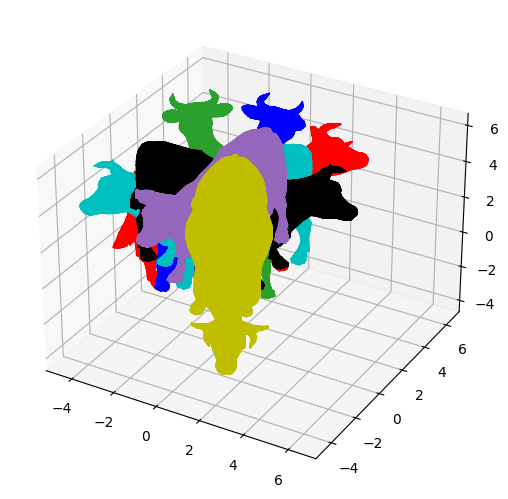

In [12]:
# %matplotlib 
%matplotlib inline
figure = plt.figure()
axes = mplot3d.Axes3D(figure)
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh_cow.vectors, edgecolors='black', facecolors='black'))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(t2_10, edgecolors='r', facecolors='r'))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(t2_11, edgecolors='b', facecolors='b'))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(t2_12, edgecolors='tab:green', facecolors='tab:green'))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(t2_13, edgecolors='c', facecolors='c'))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(t2_14, edgecolors='tab:purple', facecolors='tab:purple'))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(t2_2, edgecolors='y', facecolors='y'))
#Add the 3D faces to the created matplotlib axes
min = np.min(mesh_cow.vectors.reshape(-1))
max = np.max(mesh_cow.vectors.reshape(-1))#Find minimum and maximum units to place the cow in a cubular grid
axes.auto_scale_xyz([min, max], [min, max], [min, max])
plt.show()

#### Task 3

In [13]:
scale = 1
translation = np.array([[0], [0], [0]], dtype=np.float32)
homography = np.array([[0], [0], [0]], dtype=np.float32)

# Create transformation matrix
rotateAxis = np.array([1, 0.5, 0], dtype=np.float32)
rotateAngle = np.linalg.norm(rotateAxis)
rotateAxis = rotateAxis/np.linalg.norm(rotateAxis)
rotateHat = hatOperator(rotateAxis)
rotation = RodriguesFormula(rotateAngle, rotateHat)

H1 = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))

# Create transformation matrix
rotateAxis = np.array([0.3, 0.7, -1], dtype=np.float32)
rotateAngle = np.linalg.norm(rotateAxis)
rotateAxis = rotateAxis/np.linalg.norm(rotateAxis)
rotateHat = hatOperator(rotateAxis)
rotation = RodriguesFormula(rotateAngle, rotateHat)

H2 = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))

H = np.matmul(H2,H1)
t3_1 = transformMeshbyH(mesh_cow.vectors, H)



# Create transformation matrix
rotateAxis = np.array([0.3, 0.7, -1], dtype=np.float32)
rotateAngle = np.linalg.norm(rotateAxis)
rotateAxis = rotateAxis/np.linalg.norm(rotateAxis)
rotateHat = hatOperator(rotateAxis)
rotation = RodriguesFormula(rotateAngle, rotateHat)

H1 = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))

# Create transformation matrix
rotateAxis = np.array([1, 0.5, 0], dtype=np.float32)
rotateAngle = np.linalg.norm(rotateAxis)
rotateAxis = rotateAxis/np.linalg.norm(rotateAxis)
rotateHat = hatOperator(rotateAxis)
rotation = RodriguesFormula(rotateAngle, rotateHat)

H2 = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))

H = np.matmul(H2,H1)
t3_2 = transformMeshbyH(mesh_cow.vectors, H)

C:\Users\QP\AppData\Local\Temp\ipykernel_24952\3251121047.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(figure)


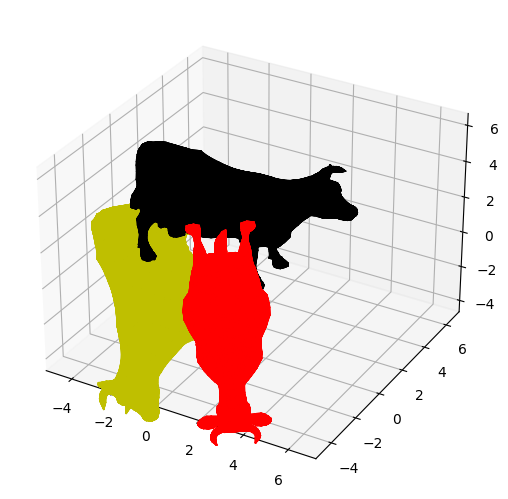

In [14]:
# %matplotlib 
%matplotlib inline
figure = plt.figure()
axes = mplot3d.Axes3D(figure)
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh_cow.vectors, edgecolors='black', facecolors='black'))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(t3_1, edgecolors='y', facecolors='y'))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(t3_2, edgecolors='r', facecolors='r'))
#Add the 3D faces to the created matplotlib axes
min = np.min(mesh_cow.vectors.reshape(-1))
max = np.max(mesh_cow.vectors.reshape(-1))#Find minimum and maximum units to place the cow in a cubular grid
axes.auto_scale_xyz([min, max], [min, max], [min, max])
plt.show()

We do not obtain the same position after (i) and (ii) because exponential mapping in Rodrigues's formula is not commutative as expected. e^w1\*e^w2 != e^w2\*e^w1

#### Task 4

In [15]:
scale = 1
translation = np.array([[0], [0], [0]], dtype=np.float32)
homography = np.array([[0], [0], [0]], dtype=np.float32)
w = np.array([1, 2, 3], dtype=np.float32)

# Create transformation matrix
rotateAxis = w + np.array([0, 0, 5], dtype=np.float32)
rotateAngle = np.linalg.norm(rotateAxis)
rotateAxis = rotateAxis/np.linalg.norm(rotateAxis)
rotateHat = hatOperator(rotateAxis)
rotation = RodriguesFormula(rotateAngle, rotateHat)

H = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))
t4_1 = transformMeshbyH(mesh_cow.vectors, H)

# Create transformation matrix
rotateAxis = w + np.array([0, 0, -5], dtype=np.float32)
rotateAngle = np.linalg.norm(rotateAxis)
rotateAxis = rotateAxis/np.linalg.norm(rotateAxis)
rotateHat = hatOperator(rotateAxis)
rotation = RodriguesFormula(rotateAngle, rotateHat)

H = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))
t4_2 = transformMeshbyH(mesh_cow.vectors, H)

# Create transformation matrix
rotateAxis = w + np.array([0, 5, 0], dtype=np.float32)
rotateAngle = np.linalg.norm(rotateAxis)
rotateAxis = rotateAxis/np.linalg.norm(rotateAxis)
rotateHat = hatOperator(rotateAxis)
rotation = RodriguesFormula(rotateAngle, rotateHat)

H = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))
t4_3 = transformMeshbyH(mesh_cow.vectors, H)

# Create transformation matrix
rotateAxis = w + np.array([0, -5, 0], dtype=np.float32)
rotateAngle = np.linalg.norm(rotateAxis)
rotateAxis = rotateAxis/np.linalg.norm(rotateAxis)
rotateHat = hatOperator(rotateAxis)
rotation = RodriguesFormula(rotateAngle, rotateHat)

H = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))
t4_4 = transformMeshbyH(mesh_cow.vectors, H)

# Create transformation matrix
rotateAxis = w + np.array([5, 0, 0], dtype=np.float32)
rotateAngle = np.linalg.norm(rotateAxis)
rotateAxis = rotateAxis/np.linalg.norm(rotateAxis)
rotateHat = hatOperator(rotateAxis)
rotation = RodriguesFormula(rotateAngle, rotateHat)

H = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))
t4_5 = transformMeshbyH(mesh_cow.vectors, H)

# Create transformation matrix
rotateAxis = w + np.array([-5, 0, 0], dtype=np.float32)
rotateAngle = np.linalg.norm(rotateAxis)
rotateAxis = rotateAxis/np.linalg.norm(rotateAxis)
rotateHat = hatOperator(rotateAxis)
rotation = RodriguesFormula(rotateAngle, rotateHat)

H = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))
t4_6 = transformMeshbyH(mesh_cow.vectors, H)

C:\Users\QP\AppData\Local\Temp\ipykernel_24952\1726536098.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(figure)


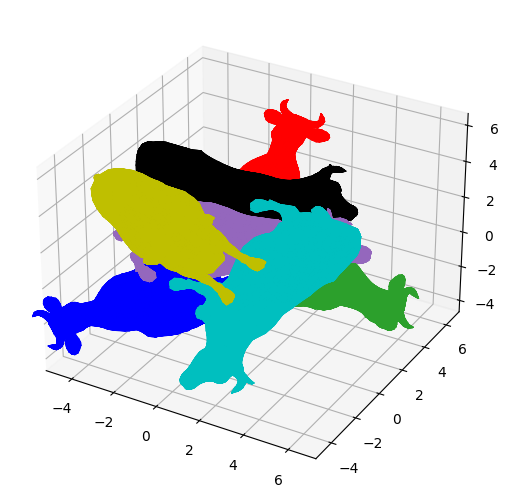

In [16]:
# %matplotlib 
%matplotlib inline
figure = plt.figure()
axes = mplot3d.Axes3D(figure)
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh_cow.vectors, edgecolors='black', facecolors='black'))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(t4_1, edgecolors='r', facecolors='r'))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(t4_2, edgecolors='b', facecolors='b'))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(t4_3, edgecolors='tab:green', facecolors='tab:green'))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(t4_4, edgecolors='c', facecolors='c'))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(t4_5, edgecolors='tab:purple', facecolors='tab:purple'))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(t4_6, edgecolors='y', facecolors='y'))
#Add the 3D faces to the created matplotlib axes
min = np.min(mesh_cow.vectors.reshape(-1))
max = np.max(mesh_cow.vectors.reshape(-1))#Find minimum and maximum units to place the cow in a cubular grid
axes.auto_scale_xyz([min, max], [min, max], [min, max])
plt.show()

#### Task 5

In [17]:
def quaternionMul(q1: np.ndarray, q2: np.ndarray) -> np.ndarray:
    """
    Calculates quaternion multiplication.
        
        Parameters:
                q1 (numpy.ndarray): First quaternion.
                q2 (numpy.ndarray): Second quaternion.
        Returns:
                Result of multiplication.
    """
    return np.array([q1[0]*q2[0] - q1[1]*q2[1] - q1[2]*q2[2] - q1[3]*q2[3],
                     q1[0]*q2[1] + q1[1]*q2[2] + q1[2]*q2[3] - q1[3]*q2[0],
                     q1[0]*q2[2] - q1[1]*q2[3] + q1[2]*q2[0] + q1[3]*q2[1],
                     q1[0]*q2[3] + q1[1]*q2[0] - q1[2]*q2[1] + q1[3]*q2[2]], dtype=np.float32)

In [18]:
def quaternionInverse(q1: np.ndarray) -> np.ndarray:
    """
    Returns conjugate quaternion.
        
        Parameters:
                q1 (numpy.ndarray): Input quaternion.
        Returns:
                Conjugate quaternion.
    """
    return np.array([q1[0] - q1[1] - q1[2] - q1[3]], dtype=np.float32)

In [19]:
def quaternionRot(theta: np.float32, axisVector: np.ndarray) -> np.ndarray:
    """
    Calculates the rotation matrix from theta to rotate around an axis which is supplied by a hat matrix of the axis.
        
        Parameters:
                theta        (numpy.ndarray): Rotation amount in radian.
                axisVector   (numpy.ndarray): Unit axis vector to compute rotation around.
        Returns:
                Rotation quaternion.
    """
    return np.array([np.cos(theta/2), np.sin(theta/2)*axisVector[0], np.sin(theta/2)*axisVector[1], np.sin(theta/2)*axisVector[2]], dtype=np.float32)


In [20]:
def rotationfromQuaternion(q: np.ndarray) -> tuple[np.float32, np.ndarray]:
    """
    Calculates the rotation axis and angle from given quaternion.
        
        Parameters:
                theta        (numpy.ndarray): Input quaternion.
        Returns:
                Rotation axis and rotation angle.
    """
    theta = 2*np.arccos(q[0])
    w = np.zeros((3,), dtype=np.float32)
    for i in range(w.shape[0]):
        w[i] = q[i]/np.sin(theta/2) if theta != 0 else 0
        
    return (theta, w)

In [21]:
scale = 1
translation = np.array([[0], [0], [0]], dtype=np.float32)
homography = np.array([[0], [0], [0]], dtype=np.float32)

w1 = np.array([1, 0.5, 0], dtype=np.float32)
theta1 = np.linalg.norm(w1)
w1 = w1/np.linalg.norm(w1)
q1 = quaternionRot(theta1, w1)

w2 = np.array([0.3, 0.7, -1], dtype=np.float32)
theta2 = np.linalg.norm(w2)
w2 = w2/np.linalg.norm(w2)
q2 = quaternionRot(theta2, w2)

qForward = quaternionMul(q2, q1)
qBackward = quaternionMul(q1, q2)

# Create transformation matrix
rotateAngle, rotateAxis = rotationfromQuaternion(qForward)
rotateAxis = rotateAxis/np.linalg.norm(rotateAxis)
rotateHat = hatOperator(rotateAxis)
rotation = RodriguesFormula(rotateAngle, rotateHat)

H = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))
t5_1 = transformMeshbyH(mesh_cow.vectors, H)

# Create transformation matrix
rotateAngle, rotateAxis = rotationfromQuaternion(qBackward)
rotateAxis = rotateAxis/np.linalg.norm(rotateAxis)
rotateHat = hatOperator(rotateAxis)
rotation = RodriguesFormula(rotateAngle, rotateHat)

H = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))
t5_2 = transformMeshbyH(mesh_cow.vectors, H)

C:\Users\QP\AppData\Local\Temp\ipykernel_24952\2525251360.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(figure)


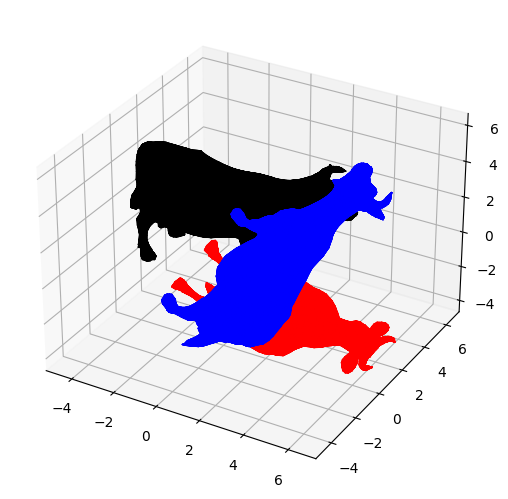

In [22]:
# %matplotlib 
%matplotlib inline
figure = plt.figure()
axes = mplot3d.Axes3D(figure)
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh_cow.vectors, edgecolors='black', facecolors='black'))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(t5_1, edgecolors='r', facecolors='r'))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(t5_2, edgecolors='b', facecolors='b'))

#Add the 3D faces to the created matplotlib axes
min = np.min(mesh_cow.vectors.reshape(-1))
max = np.max(mesh_cow.vectors.reshape(-1))#Find minimum and maximum units to place the cow in a cubular grid
axes.auto_scale_xyz([min, max], [min, max], [min, max])
plt.show()

As we can see from the figure above, quaternion rotations are also not commutative.

#### Task 6

##### i) Is there a singularity in the Exponential Coordinates? If yes, can it be overcome?

If rotation matrix is identity matrix which means rotation angle is 0, we can not define the rotation axis from the rotation matrix. For theta = 0, there is a singularity.

##### ii) Is there a singularity in Quaternions?

No, There is no singularity in Quaternions. 

##### iii) Why is the quaternion representation preferred over Euler angle representation for 3D rotations?

In Euler angle representation, we lose 1 degree of freedom and that is defined as gimbal lock. In addition, rotation pattern does not change continuously. These are the reasons why we use quaternion over Euler angle.

#### Task 7

In [23]:
def anglesfromEulerRotMatrix(R: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Calculates the rotation angles around x,y and from rotation matrix.
        
        Parameters:
                R   (numpy.ndarray): Rotation matrix.
        Returns:
                Possible rotation angles in the orde of x, y, z.
    """
    first = np.zeros(shape=(3,), dtype=np.float32)
    second = np.zeros(shape=(3,), dtype=np.float32)

    if(R[2,0] != 1 or R[2,0] != -1):
        theta1 = -np.arcsin(R[2,0])
        theta2= np.pi - theta1
        sigma1 = np.arctan2(R[2,1]/np.cos(theta1), R[2,2]/np.cos(theta1))
        sigma2 = np.arctan2(R[2,1]/np.cos(theta2), R[2,2]/np.cos(theta2))
        phi1 = np.arctan2(R[1,0]/np.cos(theta1), R[0,0]/np.cos(theta1))
        phi2 = np.arctan2(R[1,0]/np.cos(theta2), R[0,0]/np.cos(theta2))

        first[0], first[1], first[2] = sigma1, theta1, phi1
        second[0], second[1], second[2] = sigma2, theta2, phi2
    else:
        phi = 0
        if(R[2,0] == -1):
            theta = np.pi/2
            sigma = phi + np.arctan2(R[0,1], R[0,2])
        else:
            theta = -np.pi/2
            sigma = -phi + np.arctan2(-R[0,1], -R[0,2])   

        first[0], first[1], first[2] = sigma, theta, phi     
        second[0], second[1], second[2] = sigma, theta, phi  
    
    return first, second

In [24]:
def rotationMatrixfromEulerAngles(sigma: np.float32, theta: np.float32, phi: np.float32) -> np.ndarray:
    """
    Calculates the rotation matrix from rotation angles around x,y and z in order.
        
        Parameters:
                sigma   (numpy.float32): Rotation angle around x axis in radian.
                theta   (numpy.float32): Rotation angle around y axis in radian.
                phi   (numpy.float32): Rotation angle around z axis in radian.
        Returns:
                Rotation matrix
    """
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(sigma), 0-np.sin(sigma)],
                   [0, np.sin(sigma), np.cos(sigma)]], dtype=np.float32)
    Ry = np.array([[np.cos(theta), 0, np.sin(theta)],
                   [0, 1, 0],
                   [0-np.sin(theta), 0, np.cos(theta)]], dtype=np.float32)
    Rz = np.array([[np.cos(phi), 0-np.sin(phi), 0],
                   [np.sin(phi), np.cos(phi), 0],
                   [0, 0, 1]], dtype=np.float32)
    
    R = np.matmul(np.matmul(Rz,Ry), Rx)

    return R

In [25]:
Rdefault = np.array([[0.8365, -0.5245, -0.1585],
                     [0.2241, 0.5915, -0.7745],
                     [0.5000, 0.6124, 0.6124]], dtype=np.float32)

first, second = anglesfromEulerRotMatrix(Rdefault)
print(first, second)

calculatedRfirst = rotationMatrixfromEulerAngles(first[0], first[1], first[2])
calculatedRsecond = rotationMatrixfromEulerAngles(second[0], second[1], second[2])
print(calculatedRfirst)
print(calculatedRsecond)

[ 0.7853982  -0.5235988   0.26175532] [-2.3561945  3.6651914 -2.8798373]
[[ 0.8365262  -0.524493   -0.15852778]
 [ 0.22410701  0.5915295  -0.77451205]
 [ 0.5         0.6123724   0.6123724 ]]
[[ 0.8365262  -0.524493   -0.15852769]
 [ 0.22410707  0.59152937 -0.77451205]
 [ 0.49999997  0.61237246  0.61237246]]


In [26]:
scale = 1
translation = np.array([[0], [0], [0]], dtype=np.float32)
homography = np.array([[0], [0], [0]], dtype=np.float32)

# Create transformation matrix
rotation = Rdefault
H = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))
t7_1 = transformMeshbyH(mesh_cow.vectors, H)

# Create transformation matrix
rotation = calculatedRfirst
H = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))
t7_2 = transformMeshbyH(mesh_cow.vectors, H)

# Create transformation matrix
rotation = calculatedRsecond
H = np.vstack((np.hstack((scale*rotation, translation)), np.hstack((np.squeeze(np.transpose(homography)), np.array([1], dtype=np.float32)))))
t7_3 = transformMeshbyH(mesh_cow.vectors, H)

C:\Users\QP\AppData\Local\Temp\ipykernel_24952\1766327510.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(figure)


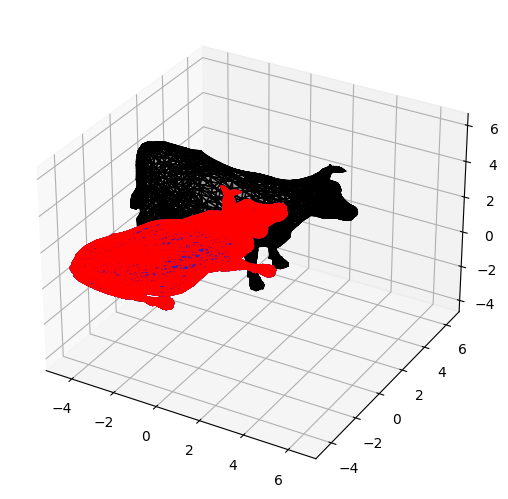

In [27]:
# %matplotlib 
%matplotlib inline
figure = plt.figure()
axes = mplot3d.Axes3D(figure)
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh_cow.vectors, edgecolors='black', facecolors='black', alpha=0.2))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(t7_1, edgecolors='r', facecolors='r', alpha=0.1))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(t7_2, edgecolors='b', facecolors='b', alpha=0.5))
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(t7_3, edgecolors='c', facecolors='c', alpha=0.9))

#Add the 3D faces to the created matplotlib axes
min = np.min(mesh_cow.vectors.reshape(-1))
max = np.max(mesh_cow.vectors.reshape(-1))#Find minimum and maximum units to place the cow in a cubular grid
axes.auto_scale_xyz([min, max], [min, max], [min, max])
plt.show()

As we can see from the figure and the printed calculated rotation matrices, our findings are true.

#### Task 8

In [28]:
import cv2
import os
import moviepy.editor as moviepy
from PIL import Image

In [29]:
planes = np.zeros((9,472,4,3))

for i in range(1,10):
	with open("other_materials/Plane_"+str(i)+".txt") as f:
		content = f.readlines()
		for line_id in range(len(content)):
			sel_line = content[line_id]
			sel_line = sel_line.replace(')\n', '').replace("(", '').split(")")

			for point_id in range(4):
				sel_point = sel_line[point_id].split(" ")

				planes[i-1,line_id,point_id,0] = float(sel_point[0])
				planes[i-1,line_id,point_id,1] = float(sel_point[1])
				planes[i-1,line_id,point_id,2] = float(sel_point[2])


cover = cv2.imread("album_cover.jpg")
cover = cv2.resize(cover, (572, 322))
cat = cv2.imread('other_materials/cat-headphones.png', cv2.IMREAD_UNCHANGED)    
#make mask of where the transparent bits are
trans_mask = cat[:,:,3] == 0
#replace areas of transparency with white and not transparent
catMask = cat.copy()
catMask[trans_mask] = [0, 0, 0, 0]
cat[trans_mask] = [255, 255, 255, 0]
#new image without alpha channel
cat = cv2.cvtColor(cat, cv2.COLOR_BGRA2BGR)
catMask = cv2.cvtColor(catMask, cv2.COLOR_BGRA2GRAY)
_, catMask = cv2.threshold(catMask, 0, 255, cv2.THRESH_BINARY)
cat = cv2.resize(cat, (572,322))
catMask = cv2.resize(catMask, (572,322))
catMaskInv = cv2.bitwise_not(catMask)

images_list = []
srcPts = np.array([[0, 0], [572, 0], [572, 322], [0, 322]], dtype=np.int32)

for i in range(472):
	infronts = []
	background = 255*np.ones(shape=(322, 572, 3),dtype=np.uint8)	
	for j in range(9):

		pts = planes[j,i,:,:].squeeze()[:,0:2].astype(np.int32)

		# 						
		# p2-------p1				p2-------p1
		# |			|		->      |		 |
		# |		    |				|		 |
		# p4-------p3				p3-------p4
		temp = np.copy(pts[3,:])
		pts[3, :] = pts[2,:]
		pts[2, :] = temp

		# q = M*A; A = M^-1 * q
		M = np.array([[srcPts[0][0], srcPts[0][1], 1, 0, 0, 0, -srcPts[0][0]*pts[0][0], -srcPts[0][1]*pts[0][0]],
					[srcPts[1][0], srcPts[1][1], 1, 0, 0, 0, -srcPts[1][0]*pts[1][0], -srcPts[1][1]*pts[1][0]],
					[srcPts[2][0], srcPts[2][1], 1, 0, 0, 0, -srcPts[2][0]*pts[2][0], -srcPts[2][1]*pts[2][0]],
					[srcPts[3][0], srcPts[3][1], 1, 0, 0, 0, -srcPts[3][0]*pts[3][0], -srcPts[3][1]*pts[3][0]],
					[0, 0, 0, srcPts[0][0], srcPts[0][1], 1, -srcPts[0][0]*pts[0][1], -srcPts[0][1]*pts[0][1]],
					[0, 0, 0, srcPts[1][0], srcPts[1][1], 1, -srcPts[1][0]*pts[1][1], -srcPts[1][1]*pts[1][1]],
					[0, 0, 0, srcPts[2][0], srcPts[2][1], 1, -srcPts[2][0]*pts[2][1], -srcPts[2][1]*pts[2][1]],
					[0, 0, 0, srcPts[3][0], srcPts[3][1], 1, -srcPts[3][0]*pts[3][1], -srcPts[3][1]*pts[3][1]]])
		InverseM = np.linalg.pinv(M)
		points = np.array([pts[0][0], pts[1][0], pts[2][0], pts[3][0], pts[0][1], pts[1][1], pts[2][1], pts[3][1]])
		A = np.matmul(InverseM, points)
		affineMatrix = np.concatenate([A, np.array([1], dtype=np.float32)]).reshape((3,3))

		coverMask = 255*np.ones(shape=(322, 572),dtype=np.uint8)
		coverWarped = cv2.warpPerspective(cover, affineMatrix, (int(572), int(322)), flags=cv2.INTER_LINEAR)
		coverMask = cv2.warpPerspective(coverMask, affineMatrix, (int(572), int(322)), flags=cv2.INTER_LINEAR)
		coverMaskInv = cv2.bitwise_not(coverMask)

		if pts[0,0] > pts[1,0]:
			background = cv2.bitwise_and(background, background, mask = coverMaskInv) + coverWarped
		else:
			infronts.append((coverMaskInv, coverWarped))

	# Add cat
	background = cv2.bitwise_and(background, background,mask = catMaskInv) + cat 

	# Add objects in front of the cat
	for k in range(len(infronts)):
		background = cv2.bitwise_and(background, background, mask = infronts[k][0]) + infronts[k][1]
	
	images_list.append(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
	
cv2.imwrite("Task8.jpg", cv2.cvtColor(images_list[0], cv2.COLOR_BGR2RGB))
clip = moviepy.ImageSequenceClip(images_list, fps = 25)
clip.write_videofile("Task8.mp4", codec="libx264")

Moviepy - Building video Task8.mp4.
Moviepy - Writing video Task8.mp4



Moviepy - Done !
Moviepy - video ready Task8.mp4


#### Task 9

In [30]:
def normalize2Dpts(A: np.ndarray) -> np.ndarray:
    """
    Finds similarity for normalization of 2D homography data points with zero mean and sqrt(2) distance to origin.
        
        Parameters:
                A   (numpy.ndarray): Input data points.
        Returns:
                Transformed points and similarity transform matrix.
    """
    # Translation
    mean = np.mean(A, axis=0)
    shifted = A - mean
    T1 = np.array([[1,      0,  -mean[0]],
                   [0,      1,  -mean[1]],
                   [0,      0,         1]], dtype=np.float32)
    for i in range(A.shape[0]):
        shifted[i] = T1@A[i]

    # Scale
    dSum = np.float32(0)
    for i in range(shifted.shape[0]):
        dSum += np.sqrt(shifted[i][0]**2 + shifted[i][1]**2)
    scale = np.sqrt(2)*shifted.shape[0]/dSum
    T2 = np.array([[scale, 0,        0],
                  [0,        scale,  0],
                  [0,        0,      1]], dtype=np.float32)
    normalized = np.zeros_like(A, dtype=np.float32)
    for i in range(shifted.shape[0]):
        normalized[i] = T2@shifted[i]

    T = T2@T1

    return normalized, T

In [31]:
def homography2D(X: np.ndarray, X_hat: np.ndarray) -> np.ndarray:
    """
    Calculates homography estimation using Direct Linear Transform.
        
        Parameters:
                X       (numpy.ndarray): Source data points.
                X_hat   (numpy.ndarray): Destination data points.
        Returns:
                H       (numpy.ndarray): Homography transformation matrix.
    """
    
    N =  X.shape[0]
    assert N == X_hat.shape[0]

    X_norm, T = normalize2Dpts(X)
    X_hat_norm, T_hat = normalize2Dpts(X_hat)
    A = np.zeros(shape=(2*N, 9))

    for i in range(N):
        zero = np.zeros(shape=(3,), dtype=np.float32)
        w_hat_x_T = X_hat_norm[i][2]*X_norm[i]
        y_hat_x_T = X_hat_norm[i][1]*X_norm[i]
        x_hat_x_T = X_hat_norm[i][0]*X_norm[i]

        A[2*i] = np.hstack((zero, -w_hat_x_T, y_hat_x_T))
        A[2*i+1] = np.hstack((w_hat_x_T, zero, -x_hat_x_T))

    u, sigma, vh = np.linalg.svd(A)

    h = np.transpose(vh)[:,-1]

    H_norm = np.vstack((h[0:3], h[3:6], h[6:9]))

    H = np.linalg.inv(T_hat)@H_norm@T

    return H

In [32]:
im1 = cv2.imread("other_materials/1.JPG")
im2 = cv2.imread("other_materials/2.JPG")
im3 = cv2.imread("other_materials/3.JPG")
imShape1 = im1.shape[0], im1.shape[1]
imShape2 = im2.shape[0], im2.shape[1]
imShape3 = im3.shape[0], im3.shape[1]
print(imShape1) # height, width
print(imShape2) # height, width
print(imShape3) # height, width

(375, 501)
(375, 501)
(375, 501)


In [33]:
import math

def perspectiveWarp(image: np.ndarray, transform: np.ndarray) -> tuple[np.ndarray, int, int]:
    """
    Warps the given image with the given transformation matrix.
        
        Parameters:
                image       (numpy.ndarray): Source image.
                transform   (numpy.ndarray): Transformation matrix.
        Returns:
                Transformed image, top left coordiantes, translation amounts.
    """
    
    h, w = image.shape[:2]
    corners_bef = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
    corners_aft = cv2.perspectiveTransform(corners_bef, transform)
    xmin = math.floor(corners_aft[:, 0, 0].min())
    ymin = math.floor(corners_aft[:, 0, 1].min())
    xmax = math.ceil(corners_aft[:, 0, 0].max())
    ymax = math.ceil(corners_aft[:, 0, 1].max())
    x_adj = math.floor(xmin - corners_aft[0, 0, 0])
    y_adj = math.floor(ymin - corners_aft[0, 0, 1])
    translate = np.eye(3)
    translate[0, 2] = -xmin
    translate[1, 2] = -ymin
    corrected_transform = np.matmul(translate, transform)
    return cv2.warpPerspective(image, corrected_transform, (math.ceil(xmax - xmin), math.ceil(ymax - ymin))), x_adj, y_adj, xmin, ymin

def mergeImages(image1: np.ndarray, image2: np.ndarray, tx, ty, alfa) -> np.ndarray:
    """
    Takes 2 images and blend them into 1 with an alfa scale. First image is a warped image with translation amout of tx and ty along x and y axis.
        
        Parameters:
                image1   (numpy.ndarray): Warped image.
                image2   (numpy.ndarray): Second image.
                tx       (numpy.ndarray): Translation along x axis.
                ty       (numpy.ndarray): Translation along y axis.
        Returns:
                Blended image.
    """

    w1, h1 = image1.shape[1], image1.shape[0]
    w2, h2 = image2.shape[1], image2.shape[0]
    print("w1: ", w1, " h1: ", h1)
    print("w2: ", w2, " h2: ", h2)
    if(ty < 0 and tx < 0):
        w, h = np.max(np.array([w1,  w2 - tx])), np.max(np.array([h1, h2+np.abs(ty)]))
    elif(ty < 0 and tx > 0):
        w, h = np.max(np.array([w2,  w1 + tx])), np.max(np.array([h1, h2+np.abs(ty)]))
    elif(ty > 0 and tx < 0):
        w, h = np.max(np.array([w1,  w2 - tx])), np.max(np.array([h2, h1+np.abs(ty)]))
    else:
        w, h = np.max(np.array([w2,  w1 + tx])), np.max(np.array([h2, h1+np.abs(ty)]))
        
    print("w: ", w, " h: ", h)
    background = np.zeros(shape=(h, w, 3), dtype=np.uint8)
    print("tx: ", tx, " ty: ", ty)
    if(ty < 0 and tx < 0):
        background[-ty:-ty+h2, -tx:-tx+w2] += image2
        for i in range(h1):
            for j in range(w1):
                yIndex = i
                xIndex = j
                if(not np.any(background[yIndex, xIndex])):
                    background[yIndex, xIndex] = image1[i, j]
                else:
                    if(np.any(image1[i, j])):
                        background[yIndex, xIndex] = alfa*background[yIndex, xIndex] + (1-alfa)*image1[i, j]
                    else:
                        pass
    elif(ty < 0 and tx > 0):
        background[-ty:-ty+h2, :w2] += image2
        for i in range(h1):
            for j in range(w1):
                yIndex = i
                xIndex = j + tx
                if(not np.any(background[yIndex, xIndex])):
                    background[yIndex, xIndex] = image1[i, j]
                else:
                    if(np.any(image1[i, j])):
                        background[yIndex, xIndex] = alfa*background[yIndex, xIndex] + (1-alfa)*image1[i, j]
                    else:
                        pass
    elif(ty > 0 and tx < 0):
        background[:h2, -tx:-tx+w2] += image2
        for i in range(h1):
            for j in range(w1):
                yIndex = i + ty
                xIndex = j
                if(not np.any(background[yIndex, xIndex])):
                    background[yIndex, xIndex] = image1[i, j]
                else:
                    if(np.any(image1[i, j])):
                        background[yIndex, xIndex] = alfa*background[yIndex, xIndex] + (1-alfa)*image1[i, j]
                    else:
                        pass    
    else:
        background[:h2, :w2] += image2
        for i in range(h1):
            for j in range(w1):
                yIndex = i + ty
                xIndex = j + tx
                if(not np.any(background[yIndex, xIndex])):
                    background[yIndex, xIndex] = image1[i, j]
                else:
                    if(np.any(image1[i, j])):
                        background[yIndex, xIndex] = alfa*background[yIndex, xIndex] + (1-alfa)*image1[i, j]
                    else:
                        pass
    return background

In [34]:
# First image points
X1 = np.array([[397, 121, 1],
               [327, 172, 1],
               [342, 229, 1],
               [366, 196, 1],
               [416, 125, 1],
               [469, 228, 1]])

# Second image points
X2 = np.array([[109, 94, 1],
               [38, 144, 1],
               [53, 202, 1],
               [77, 169, 1],
               [128, 99, 1],
               [178, 202, 1]])

H1 = homography2D(X1, X2)
print("Homography 1:\n", H1)

# first 2 images
warped1, xa1, ya1, tx1, ty1 = perspectiveWarp(im1, H1)
print("xa1: ", xa1, " ya1: ", ya1, " tx1: ", tx1, " ty1: ", ty1)
alfa1 = 0.5
merged1 = mergeImages(warped1, im2, tx1, ty1, alfa1)

cv2.imshow("merged", merged1)
cv2.waitKey(0)
cv2.destroyAllWindows()
# cv2.imwrite("Task9Im1.jpg", merged1)

Homography 1:
 [[ 5.85944184e-01 -6.67340845e-04 -1.69940208e+02]
 [ 2.95580165e-02  5.86046242e-01 -2.86005148e+01]
 [ 1.20375243e-04  5.33858421e-05  5.19744913e-01]]
xa1:  -1  ya1:  -1  tx1:  -327  ty1:  -56
w1:  541  h1:  411
w2:  501  h2:  375
w:  828  h:  431
tx:  -327  ty:  -56


In [35]:
# First image points
X3 = np.array([[68, 108, 1],
               [90, 172, 1],
               [23, 185, 1],
               [87, 149, 1],
               [178, 177, 1],
               [56, 157, 1]])

# Second image points
X2_2 = np.array([[372, 125, 1],
               [394, 188, 1],
               [328, 201, 1],
               [392, 165, 1],
               [483, 193, 1],
               [360, 173, 1]])


H2 = homography2D(X3, X2_2)
print("Homography 2:\n", H2)

# second 2 images
warped2, xa2, ya2, tx2, ty2 = perspectiveWarp(im3, H2)
print("xa2: ", xa2, " ya2: ", ya2, " tx2: ", tx2, " ty2: ", ty2)
alfa2 = 0.5
merged2 = mergeImages(warped2, im2, tx2, ty2, alfa2)

cv2.imshow("merged2", merged2)
cv2.waitKey(0)
cv2.destroyAllWindows()
# cv2.imwrite("Task9Im2.jpg", merged2)

Homography 2:
 [[ 5.58162462e-01 -4.59105057e-03  1.78829732e+02]
 [-1.01101471e-02  5.70134086e-01  1.16658072e+01]
 [-5.16873237e-05 -1.87583967e-05  5.86743277e-01]]
xa2:  -1  ya2:  -9  tx2:  304  ty2:  11
w1:  521  h1:  387
w2:  501  h2:  375
w:  825  h:  398
tx:  304  ty:  11


In [36]:
def merge(im1, im2, tx1, tx2, ty1, ty2):
    h1, w1 = im1.shape[0], im1.shape[1]
    h2, w2 = im2.shape[0], im2.shape[1]
    if(ty1 > 0 and ty2 > 0):
        h = max([h1, h2])
    elif(ty1 > 0 and ty2 < 0):
        h = h1 - ty2
    elif(ty1 < 0 and ty2 > 0):
        h = h2 - ty1
    else:
        h = max([h1, h2])

    if(tx1 > 0 and tx2 > 0):
        w = max([w1, w2])
    elif(tx1 > 0 and tx2 < 0):
        w = w1 - tx2
    elif(tx1 < 0 and tx2 > 0):
        w = w2 - tx1
    else:
        w = max([w1, w2])

    print("w1: ", w1, " h1: ", h1)
    print("w2: ", w2, " h2: ", h2)
    print("w: ", w, " h: ", h)
    print("tx1: ", tx1, " ty1: ", ty1)
    print("tx2: ", tx2, " ty2: ", ty2)

    final = np.zeros(shape=(h, w, 3), dtype=np.uint8)
    final[:h1, :w1] += im1

    for i in range(h2):
        for j in range(w2):
            yIndex = i - ty1
            xIndex = j - tx1
            if(not np.any(final[yIndex, xIndex])):
                final[yIndex, xIndex] = im2[i, j]
    return final

In [37]:
final = merge(merged1, merged2, tx1, tx2, ty1, ty2)

cv2.imshow("final", final)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite("Task9Im3.jpg", final)

w1:  828  h1:  431
w2:  825  h2:  398
w:  1152  h:  454
tx1:  -327  ty1:  -56
tx2:  304  ty2:  11


True

#### Task 10

In [38]:
def findH_SIFT(queryPath, trainPath, Lowe, MIN_MATCH_COUNT = 5):
    im1Gray = cv2.imread(queryPath, cv2.IMREAD_GRAYSCALE)          # queryImage
    im2Gray = cv2.imread(trainPath, cv2.IMREAD_GRAYSCALE)          # trainImage
    # Initiate SIFT detector
    sift = cv2.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(im1Gray,None)
    kp2, des2 = sift.detectAndCompute(im2Gray,None)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < Lowe*n.distance:
            good.append(m)

    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        SIFT, mask = cv2.findHomography(src_pts, dst_pts)
        RANSAC_25, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 25.0)
        RANSAC_5, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        RANSAC_1, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0)
        return {"SIFT": SIFT, "RANSAC_25": RANSAC_25, "RANSAC_5": RANSAC_5, "RANSAC_1": RANSAC_1}

    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        return None

In [39]:
Lowe = 0.3
H1s = findH_SIFT('other_materials/1.JPG', 'other_materials/2.JPG', Lowe)

print("Homography 1 SIFT:\n", H1s["SIFT"])
# first 2 images
warped1SIFT, xa1, ya1, tx1, ty1 = perspectiveWarp(im1, H1s["SIFT"])
print("xa1: ", xa1, " ya1: ", ya1, " tx1: ", tx1, " ty1: ", ty1)

# cv2.imshow("warped1SIFT", warped1SIFT)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


alfa1 = 0.5
merged1SIFT = mergeImages(warped1SIFT, im2, tx1, ty1, alfa1)

print("Homography 1 RANSAC_25:\n", H1s["RANSAC_25"])
# first 2 images
warped1RANSAC_25, xa1, ya1, tx1, ty1 = perspectiveWarp(im1, H1s["RANSAC_25"])
print("xa1: ", xa1, " ya1: ", ya1, " tx1: ", tx1, " ty1: ", ty1)
alfa1 = 0.5
merged1RANSAC_25 = mergeImages(warped1RANSAC_25, im2, tx1, ty1, alfa1)

print("Homography 1 RANSAC_5:\n", H1s["RANSAC_5"])
# first 2 images
warped1RANSAC_5, xa1, ya1, tx1, ty1 = perspectiveWarp(im1, H1s["RANSAC_5"])
print("xa1: ", xa1, " ya1: ", ya1, " tx1: ", tx1, " ty1: ", ty1)
alfa1 = 0.5
merged1RANSAC_5 = mergeImages(warped1RANSAC_5, im2, tx1, ty1, alfa1)

print("Homography 1 RANSAC_1:\n", H1s["RANSAC_1"])
# first 2 images
warped1RANSAC_1, xa1, ya1, tx1, ty1 = perspectiveWarp(im1, H1s["RANSAC_1"])
print("xa1: ", xa1, " ya1: ", ya1, " tx1: ", tx1, " ty1: ", ty1)
alfa1 = 0.5
merged1RANSAC_1 = mergeImages(warped1RANSAC_1, im2, tx1, ty1, alfa1)


cv2.imshow("merged1SIFT", merged1SIFT)
cv2.imshow("merged1RANSAC_25", merged1RANSAC_25)
cv2.imshow("merged1RANSAC_5", merged1RANSAC_5)
cv2.imshow("merged1RANSAC_1", merged1RANSAC_1)
cv2.waitKey(0)
cv2.destroyAllWindows()
# cv2.imwrite("Task10Im1SIFT.jpg", merged1SIFT)
# cv2.imwrite("Task10Im1RANSAC_25.jpg", merged1RANSAC_25)
# cv2.imwrite("Task10Im1RANSAC_5.jpg", merged1RANSAC_5)
# cv2.imwrite("Task10Im1RANSAC_1.jpg", merged1RANSAC_1)

Homography 1 SIFT:
 [[ 4.19904369e-01  1.84269510e-02 -1.11345716e+02]
 [-2.08520349e-01  6.21503507e-01  5.69326082e+01]
 [-1.27403787e-03  3.76606195e-04  1.00000000e+00]]
xa1:  -1  ya1:  -189  tx1:  -112  ty1:  -132
w1:  386  h1:  501
w2:  501  h2:  375
w:  613  h:  507
tx:  -112  ty:  -132
Homography 1 RANSAC_25:
 [[ 1.00382349e+00 -4.10099295e-03 -2.88694430e+02]
 [ 1.02638629e-02  1.01841842e+00 -3.30656862e+01]
 [-1.95848513e-05  8.01994090e-05  1.00000000e+00]]
xa1:  -1  ya1:  -1  tx1:  -289  ty1:  -34
w1:  506  h1:  381
w2:  501  h2:  375
w:  790  h:  409
tx:  -289  ty:  -34
Homography 1 RANSAC_5:
 [[ 1.09789974e+00 -9.89988618e-03 -3.16633991e+02]
 [ 4.81640532e-02  1.08260127e+00 -4.80460785e+01]
 [ 2.01689485e-04  1.35204133e-05  1.00000000e+00]]
xa1:  -3  ya1:  -1  tx1:  -319  ty1:  -49
w1:  531  h1:  406
w2:  501  h2:  375
w:  820  h:  424
tx:  -319  ty:  -49
Homography 1 RANSAC_1:
 [[ 1.09732072e+00 -9.95602206e-03 -3.16452881e+02]
 [ 4.79680910e-02  1.08207120e+00 -4.79

In [40]:
Lowe = 0.3
H2s = findH_SIFT('other_materials/3.JPG', 'other_materials/2.JPG', Lowe)

print("Homography 2 SIFT:\n", H2s["SIFT"])
# first 2 images
warped2SIFT, xa2, ya2, tx2, ty2 = perspectiveWarp(im3, H2s["SIFT"])
print("xa2: ", xa2, " ya2: ", ya2, " tx2: ", tx2, " ty2: ", ty2)
alfa1 = 0.5
merged2SIFT = mergeImages(warped2SIFT, im2, tx2, ty2, alfa1)

print("Homography 2 RANSAC_25:\n", H2s["RANSAC_25"])
# first 2 images
warped2RANSAC_25, xa2, ya2, tx2, ty2 = perspectiveWarp(im3, H2s["RANSAC_25"])
print("xa2: ", xa2, " ya2: ", ya2, " tx2: ", tx2, " ty2: ", ty2)
alfa1 = 0.5
merged2RANSAC_25 = mergeImages(warped2RANSAC_25, im2, tx2, ty2, alfa1)

print("Homography 2 RANSAC_5:\n", H2s["RANSAC_5"])
# first 2 images
warped2RANSAC_5, xa2, ya2, tx2, ty2 = perspectiveWarp(im3, H2s["RANSAC_5"])
print("xa2: ", xa2, " ya2: ", ya2, " tx2: ", tx2, " ty2: ", ty2)
alfa1 = 0.5
merged2RANSAC_5 = mergeImages(warped2RANSAC_5, im2, tx2, ty2, alfa1)

print("Homography 2 RANSAC_1:\n", H2s["RANSAC_1"])
# first 2 images
warped2RANSAC_1, xa2, ya2, tx2, ty2 = perspectiveWarp(im3, H2s["RANSAC_1"])
print("xa2: ", xa2, " ya2: ", ya2, " tx2: ", tx2, " ty2: ", ty2)
alfa1 = 0.5
merged2RANSAC_1 = mergeImages(warped2RANSAC_1, im2, tx2, ty2, alfa1)


cv2.imshow("merged2SIFT", merged2SIFT)
cv2.imshow("merged2RANSAC_25", merged2RANSAC_25)
cv2.imshow("merged2RANSAC_5", merged2RANSAC_5)
cv2.imshow("merged2RANSAC_1", merged2RANSAC_1)
cv2.waitKey(0)
cv2.destroyAllWindows()
# cv2.imwrite("Task10Im2SIFT.jpg", merged2SIFT)
# cv2.imwrite("Task10Im2RANSAC_25.jpg", merged2RANSAC_25)
# cv2.imwrite("Task10Im2RANSAC_5.jpg", merged2RANSAC_5)
# cv2.imwrite("Task10Im2RANSAC_1.jpg", merged2RANSAC_1)

Homography 2 SIFT:
 [[ 1.28491661e+00 -2.85320944e-02  3.03429124e+02]
 [ 1.16020696e-01  1.05411099e+00  4.92087771e+00]
 [ 6.20459416e-04 -5.34138283e-05  1.00000000e+00]]
xa2:  -6  ya2:  -1  tx2:  298  ty2:  4
w1:  428  h1:  405
w2:  501  h2:  375
w:  726  h:  409
tx:  298  ty:  4
Homography 2 RANSAC_25:
 [[ 9.08969822e-01 -9.29000716e-03  3.06345084e+02]
 [-3.25154500e-02  9.79105534e-01  1.88046529e+01]
 [-1.86352621e-04 -1.28447742e-05  1.00000000e+00]]
xa2:  -3  ya2:  -17  tx2:  304  ty2:  2
w1:  537  h1:  408
w2:  501  h2:  375
w:  841  h:  410
tx:  304  ty:  2
Homography 2 RANSAC_5:
 [[ 9.08969822e-01 -9.29000716e-03  3.06345084e+02]
 [-3.25154500e-02  9.79105534e-01  1.88046529e+01]
 [-1.86352621e-04 -1.28447742e-05  1.00000000e+00]]
xa2:  -3  ya2:  -17  tx2:  304  ty2:  2
w1:  537  h1:  408
w2:  501  h2:  375
w:  841  h:  410
tx:  304  ty:  2
Homography 2 RANSAC_1:
 [[ 9.08785932e-01 -1.15078335e-02  3.06449554e+02]
 [-3.23850708e-02  9.77527944e-01  1.89234876e+01]
 [-1.855

In [41]:
warped1SIFT, xa1, ya1, tx1, ty1 = perspectiveWarp(im1, H1s["SIFT"])
warped2SIFT, xa2, ya2, tx2, ty2 = perspectiveWarp(im3, H2s["SIFT"])
finalSIFT = merge(merged1SIFT, merged2SIFT, tx1, tx2, ty1, ty2)

warped1RANSAC_25, xa1, ya1, tx1, ty1 = perspectiveWarp(im1, H1s["RANSAC_25"])
warped2RANSAC_25, xa2, ya2, tx2, ty2 = perspectiveWarp(im3, H2s["RANSAC_25"])
finalRANSAC_25 = merge(merged1RANSAC_25, merged2RANSAC_25, tx1, tx2, ty1, ty2)

warped1RANSAC_5, xa1, ya1, tx1, ty1 = perspectiveWarp(im1, H1s["RANSAC_5"])
warped2RANSAC_5, xa2, ya2, tx2, ty2 = perspectiveWarp(im3, H2s["RANSAC_5"])
finalRANSAC_5 = merge(merged1RANSAC_5, merged2RANSAC_5, tx1, tx2, ty1, ty2)

warped1RANSAC_1, xa1, ya1, tx1, ty1 = perspectiveWarp(im1, H1s["RANSAC_5"])
warped2RANSAC_1, xa2, ya2, tx2, ty2 = perspectiveWarp(im3, H2s["RANSAC_5"])
finalRANSAC_1 = merge(merged1RANSAC_1, merged2RANSAC_1, tx1, tx2, ty1, ty2)

cv2.imshow("finalSIFT", finalSIFT)
cv2.imshow("finalRANSAC_25", finalRANSAC_25)
cv2.imshow("finalRANSAC_5", finalRANSAC_5)
cv2.imshow("finalRANSAC_1", finalRANSAC_1)
cv2.waitKey(0)
cv2.destroyAllWindows()
# cv2.imwrite("Task10Im3SIFT.jpg", finalSIFT)
# cv2.imwrite("Task10Im3RANSAC_25.jpg", finalRANSAC_25)
# cv2.imwrite("Task10Im3RANSAC_5.jpg", finalRANSAC_5)
# cv2.imwrite("Task10Im3RANSAC_1.jpg", finalRANSAC_1)

w1:  613  h1:  507
w2:  726  h2:  409
w:  838  h:  541
tx1:  -112  ty1:  -132
tx2:  298  ty2:  4
w1:  790  h1:  409
w2:  841  h2:  410
w:  1130  h:  444
tx1:  -289  ty1:  -34
tx2:  304  ty2:  2
w1:  820  h1:  424
w2:  841  h2:  410
w:  1160  h:  459
tx1:  -319  ty1:  -49
tx2:  304  ty2:  2
w1:  820  h1:  423
w2:  842  h2:  411
w:  1161  h:  460
tx1:  -319  ty1:  -49
tx2:  304  ty2:  2


#### Task 11

In [42]:
cvprIm1 = cv2.imread("t1.jpg")
cvprIm2 = cv2.imread("t2.jpg")

cvprIm1Shape = cvprIm1.shape[0], cvprIm1.shape[1]
cvprIm2Shape = cvprIm2.shape[0], cvprIm2.shape[1]
print(cvprIm1Shape) # height, width
print(cvprIm2Shape) # height, width
cvprIm1 = cv2.resize(cvprIm1, (cvprIm2Shape[1], cvprIm2Shape[0]), interpolation = cv2.INTER_AREA)
cvprIm1Shape = cvprIm1.shape[0], cvprIm1.shape[1]
print(cvprIm1Shape) # height, width

cv2.imshow("cvprIm1", cvprIm1)
cv2.imshow("cvprIm2", cvprIm2)
cv2.waitKey(0)
cv2.destroyAllWindows()

(760, 1013)
(768, 1027)
(768, 1027)


In [44]:
Lowe = 0.3
CVPRHs = findH_SIFT('t1.jpg', 't2.jpg', Lowe)

print("CVPR Homography 2 SIFT:\n", CVPRHs["SIFT"])
# first 2 images
CVPRWarpedSIFT, xa1, ya1, tx1, ty1 = perspectiveWarp(cvprIm1, CVPRHs["SIFT"])
print("xa1: ", xa1, " ya1: ", ya1, " tx1: ", tx1, " ty1: ", ty1)


# cv2.imshow("CVPRWarpedSIFT", CVPRWarpedSIFT)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

alfa1 = 0.5
CVPRMergedSIFT = mergeImages(CVPRWarpedSIFT, cvprIm2, tx1, ty1, alfa1)

print("CVPR Homography 2 RANSAC_25:\n", CVPRHs["RANSAC_25"])
# first 2 images
CVPRWarpedRANSAC_25, xa1, ya1, tx1, ty1 = perspectiveWarp(cvprIm1, CVPRHs["RANSAC_25"])
print("xa1: ", xa1, " ya1: ", ya1, " tx1: ", tx1, " ty1: ", ty1)
alfa1 = 0.5
CVPRMergedRANSAC_25 = mergeImages(CVPRWarpedRANSAC_25, cvprIm2, tx1, ty1, alfa1)

print("CVPR Homography 2 RANSAC_5:\n", CVPRHs["RANSAC_5"])
# first 2 images
CVPRWarpedRANSAC_5, xa1, ya1, tx1, ty1 = perspectiveWarp(cvprIm1, CVPRHs["RANSAC_5"])
print("xa1: ", xa1, " ya1: ", ya1, " tx1: ", tx1, " ty1: ", ty1)
alfa1 = 0.5
CVPRMergedRANSAC_5 = mergeImages(CVPRWarpedRANSAC_5, cvprIm2, tx1, ty1, alfa1)

print("CVPR Homography 2 RANSAC_1:\n", CVPRHs["RANSAC_1"])
# first 2 images
CVPRWarpedRANSAC_1, xa1, ya1, tx1, ty1 = perspectiveWarp(cvprIm1, CVPRHs["RANSAC_1"])
print("xa1: ", xa1, " ya1: ", ya1, " tx1: ", tx1, " ty1: ", ty1)
alfa1 = 0.5
CVPRMergedRANSAC_1 = mergeImages(CVPRWarpedRANSAC_1, cvprIm2, tx1, ty1, alfa1)


cv2.imshow("CVPRMergedSIFT", CVPRMergedSIFT)
cv2.imshow("CVPRMergedRANSAC_25", CVPRMergedRANSAC_25)
cv2.imshow("CVPRMergedRANSAC_5", CVPRMergedRANSAC_5)
cv2.imshow("CVPRMergedRANSAC_1", CVPRMergedRANSAC_1)
cv2.waitKey(0)
cv2.destroyAllWindows()
# cv2.imwrite("Task11ImSIFT.jpg", CVPRMergedSIFT)
# cv2.imwrite("Task11ImRANSAC_25.jpg", CVPRMergedRANSAC_25)
# cv2.imwrite("Task11ImRANSAC_5.jpg", CVPRMergedRANSAC_5)
# cv2.imwrite("Task11ImRANSAC_1.jpg", CVPRMergedRANSAC_1)

CVPR Homography 2 SIFT:
 [[ 1.96485793e+00 -3.21147033e-01 -1.02937245e+03]
 [ 9.12176821e-01  1.76424180e+00 -4.44809020e+02]
 [ 1.29473046e-03  1.47627496e-04  1.00000000e+00]]
xa1:  -118  ya1:  -1  tx1:  -1147  ty1:  -445
w1:  1572  h1:  1263
w2:  1027  h2:  768
w:  2174  h:  1263
tx:  -1147  ty:  -445
CVPR Homography 2 RANSAC_25:
 [[ 1.96485793e+00 -3.21147033e-01 -1.02937245e+03]
 [ 9.12176821e-01  1.76424180e+00 -4.44809020e+02]
 [ 1.29473046e-03  1.47627496e-04  1.00000000e+00]]
xa1:  -118  ya1:  -1  tx1:  -1147  ty1:  -445
w1:  1572  h1:  1263
w2:  1027  h2:  768
w:  2174  h:  1263
tx:  -1147  ty:  -445
CVPR Homography 2 RANSAC_5:
 [[ 1.43652250e+00 -3.38797904e-01 -7.04985705e+02]
 [ 6.06849047e-01  1.15497216e+00 -2.06645348e+02]
 [ 8.04986883e-04 -1.87197862e-04  1.00000000e+00]]
xa1:  -424  ya1:  -1  tx1:  -1128  ty1:  -207
w1:  1550  h1:  1002
w2:  1027  h2:  768
w:  2155  h:  1002
tx:  -1128  ty:  -207
CVPR Homography 2 RANSAC_1:
 [[ 1.96485793e+00 -3.21147033e-01 -1.0293